#### Import Essential Libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

##### Download The Dataset & Define The Transforms

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



1.3%

100.0%


Extracting drive/My Drive/mnist/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting drive/My Drive/mnist/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



4.0%

100.0%


Extracting drive/My Drive/mnist/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%

Extracting drive/My Drive/mnist/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST\raw



##### Checking Image and Label Shapes

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


##### Displaying a Sample Image from the Training Set

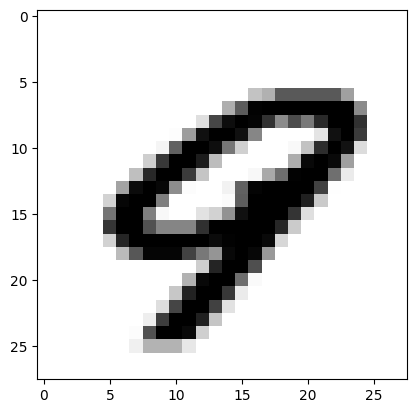

In [4]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

##### Displaying more images

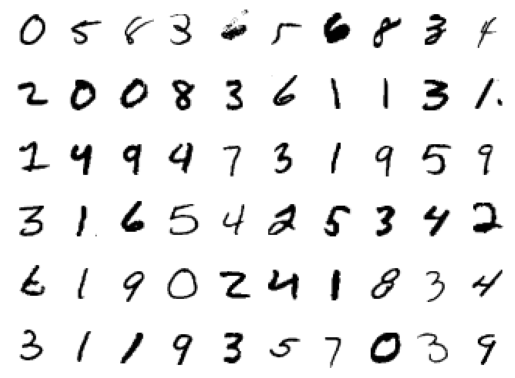

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

##### Build The Neural Network

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


##### Calculating Negative Log Likelihood Loss 

In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss


##### Adjusting Weights

In [8]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        ...,
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [ 0.0045,  0.0045,  0.0045,  ...,  0.0045,  0.0045,  0.0045]])


##### Custom Neural Network with Backpropagation

In [9]:
import torch
import torch.nn.functional as F

class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = torch.randn(input_dim, output_dim, requires_grad=False) * (2 / (input_dim + output_dim)) ** 0.5
        self.bias = torch.zeros(1, output_dim, requires_grad=False)
    
    def forward(self, x):
        self.input = x
        return x @ self.weights + self.bias
    
    def backward(self, grad_output, learning_rate, momentum=0):
        # Gradient of loss w.r.t weights and bias
        grad_weights = self.input.T @ grad_output
        grad_bias = grad_output.sum(0, keepdim=True)
        
        # Gradient of loss w.r.t input to propagate to previous layer
        grad_input = grad_output @ self.weights.T
        
        # Update weights with momentum
        self.weights_velocity = momentum * getattr(self, 'weights_velocity', 0) + learning_rate * grad_weights
        self.bias_velocity = momentum * getattr(self, 'bias_velocity', 0) + learning_rate * grad_bias

        self.weights -= self.weights_velocity
        self.bias -= self.bias_velocity
        
        return grad_input

class ReLU:
    def forward(self, x):
        self.input = x
        return torch.clamp(x, min=0)
    
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self.input <= 0] = 0
        return grad_input

class Dropout:
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def forward(self, x, train=True):
        if train:
            self.mask = (torch.rand(x.shape) > self.prob).float()
            return x * self.mask
        else:
            return x * (1 - self.prob)
    
    def backward(self, grad_output):
        return grad_output * self.mask

class CustomNetwork:
    def __init__(self, dropout_prob=0.5):
        self.layer1 = Linear(784, 256)
        self.activation1 = ReLU()
        self.dropout1 = Dropout(dropout_prob)
        
        self.layer2 = Linear(256, 128)
        self.activation2 = ReLU()
        self.dropout2 = Dropout(dropout_prob)
        
        self.layer3 = Linear(128, 64)
        self.activation3 = ReLU()
        
        self.output_layer = Linear(64, 10)
    
    def forward(self, x, train=True):
        x = self.layer1.forward(x)
        x = self.activation1.forward(x)
        x = self.dropout1.forward(x, train=train)
        
        x = self.layer2.forward(x)
        x = self.activation2.forward(x)
        x = self.dropout2.forward(x, train=train)
        
        x = self.layer3.forward(x)
        x = self.activation3.forward(x)
        
        x = self.output_layer.forward(x)
        return F.softmax(x, dim=1)
    
    def backward(self, grad_output, learning_rate, momentum=0.9):
        grad_output = self.output_layer.backward(grad_output, learning_rate, momentum)
        grad_output = self.activation3.backward(grad_output)
        
        grad_output = self.layer3.backward(grad_output, learning_rate, momentum)
        grad_output = self.dropout2.backward(grad_output)
        grad_output = self.activation2.backward(grad_output)
        
        grad_output = self.layer2.backward(grad_output, learning_rate, momentum)
        grad_output = self.dropout1.backward(grad_output)
        grad_output = self.activation1.backward(grad_output)
        
        grad_output = self.layer1.backward(grad_output, learning_rate, momentum)


Training

Epoch 1 - Training loss: 1.6520410063170166
Epoch 2 - Training loss: 1.565916459824739
Epoch 3 - Training loss: 1.5458466353446945
Epoch 4 - Training loss: 1.5341800727061372
Epoch 5 - Training loss: 1.5273093965007807
Epoch 6 - Training loss: 1.52255762843435
Epoch 7 - Training loss: 1.517548509879407
Epoch 8 - Training loss: 1.5126885478176288
Epoch 9 - Training loss: 1.5109612326632176
Epoch 10 - Training loss: 1.509438374530532
Epoch 11 - Training loss: 1.5061356210505277
Epoch 12 - Training loss: 1.5037679954378336
Epoch 13 - Training loss: 1.5021293159486897
Epoch 14 - Training loss: 1.5011296525184534
Epoch 15 - Training loss: 1.4999552996936383

Training Time (in minutes) = 2.9133201956748964


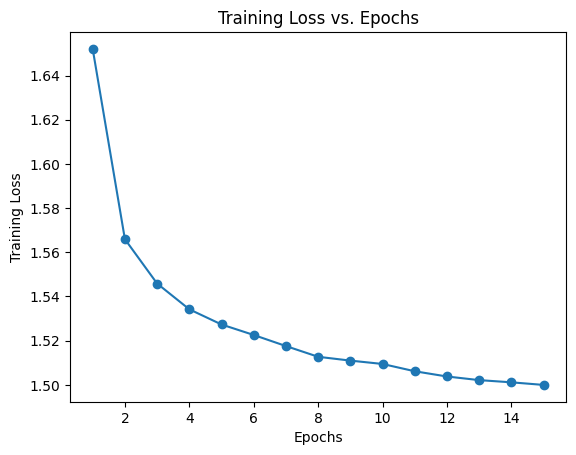

In [10]:
# Training loop with improved model structure and momentum
epochs = 15
learning_rate = 0.0005
momentum = 0.9
dropout_prob = 0.2

model = CustomNetwork(dropout_prob=dropout_prob)
training_losses = []  # List to store loss for each epoch

time0 = time()
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)  # Flatten images
        
        # Forward pass with dropout enabled
        with torch.no_grad():
            ps = model.forward(images, train=True)
        
        loss = F.cross_entropy(ps, labels)
        
        # Backpropagation
        grad_output = (ps - F.one_hot(labels, num_classes=10)).float()
        model.backward(grad_output, learning_rate, momentum=momentum)

        running_loss += loss.item()
    
    avg_loss = running_loss / len(trainloader)
    training_losses.append(avg_loss)  # Store average loss for the epoch
    print(f"Epoch {e+1} - Training loss: {avg_loss}")

print("\nTraining Time (in minutes) =", (time() - time0) / 60)

# Plotting the training loss vs. epochs
plt.plot(range(1, epochs + 1), training_losses, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs")
plt.show()

##### Validation

Predicted Digit = 5


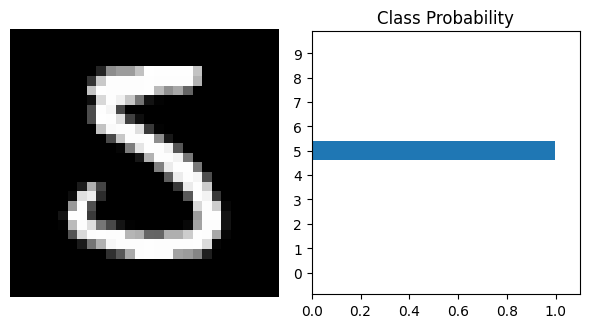

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def view_classify(img, ps):
    ''' Function for viewing an image and its predicted classes. '''
    ps = ps.squeeze().numpy()  # Convert tensor to numpy array and remove batch dimension

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.view(1, 28, 28).numpy().squeeze(), cmap='gray')  # Display the image in grayscale
    ax1.axis('off')
    
    ax2.barh(np.arange(10), ps)  # Display the probability as a bar graph
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

# Get a batch of validation images
images, labels = next(iter(valloader))

# Take one image for visualization
img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    ps = model.forward(img)  # Call the forward method directly

# Convert the probability tensor to a list and find the predicted class
probab = ps.numpy().squeeze()
print("Predicted Digit =", probab.argmax())  # Use .argmax() to get the index of the highest probability

# View the image and its predicted class probabilities
view_classify(img.view(1, 28, 28), ps)



##### Model Evaluation

In [12]:
correct_count, all_count = 0, 0

for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        
        # Turn off gradients to speed up this part
        with torch.no_grad():
            ps = model.forward(img)  # Directly call the forward method

        # Convert the probability tensor to a numpy array and find the predicted label
        probab = ps.numpy().squeeze()
        pred_label = probab.argmax()  # Get index of highest probability
        true_label = labels[i].item()  # Convert tensor to an integer

        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count / all_count))


Number Of Images Tested = 10000

Model Accuracy = 0.9673
